In [24]:
import xgboost as xgb
from data_utils import load_features, preds_to_df
from transforms import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
patient = 1

%time X_corr, y, files_1 = load_features('train_{}'.format(patient), [CorrelationMatrix()])
# %time X_mean_abs, y, files_2 = load_features('train_{}'.format(patient), [Mean(), Abs()])
# %time X_stats, y, files_3 = load_features('train_{}'.format(patient), [Stats()])
# %time X_fft, y, files_3 = load_features('train_{}'.format(patient), [FFT(), Slice(1, 160), Magnitude(), Log10()])

Wall time: 111 ms


In [112]:
files_1[0], files_2[0], files_3[0]

('1_1000_0.mat', '1_2.mat', '1_2.mat')

In [113]:
# X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
# X_stats = X_stats.reshape(X_stats.shape[0], X_stats.shape[1]*X_stats.shape[2])
# X = np.hstack([X_fft, X_mean_abs, X_corr, X_stats])
X = X_corr
sm = SMOTE(kind='regular')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1337)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [114]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [115]:
param = {'bst:max_depth':4, 'bst:eta':.5, 'silent':0, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist  = [(dtrain,'train'), (dtest,'eval')]
num_round = 100
bst = xgb.train( param, dtrain, num_round, evallist, early_stopping_rounds=4 )
roc_auc_score(np.round(bst.predict(dtrain)), y_train), roc_auc_score(np.round(bst.predict(dtest)), y_test)

Will train until eval error hasn't decreased in 4 rounds.
[0]	train-auc:0.884739	eval-auc:0.775141
[1]	train-auc:0.916520	eval-auc:0.803229
[2]	train-auc:0.944702	eval-auc:0.779659
[3]	train-auc:0.959083	eval-auc:0.770702
[4]	train-auc:0.967399	eval-auc:0.761235
[5]	train-auc:0.974741	eval-auc:0.768856
Stopping. Best iteration:
[1]	train-auc:0.916520	eval-auc:0.803229



(0.92708058690149753, 0.58065359477124179)

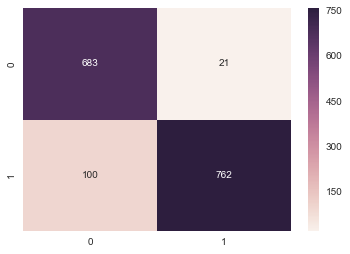

In [116]:
sns.heatmap(confusion_matrix(np.round(bst.predict(dtrain)), y_train), annot=True, fmt='d')
plt.show()

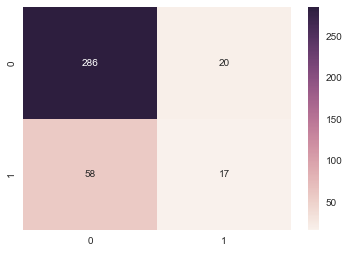

In [117]:
sns.heatmap(confusion_matrix(np.round(bst.predict(dtest)), y_test), annot=True, fmt='d')
plt.show()

In [118]:
%time X_corr, files = load_features('test_{}'.format(patient), [CorrelationMatrix()])
# %time X_mean_abs, files_2 = load_features('test_{}'.format(patient), [Mean(), Abs()])
# %time X_stats, files_3 = load_features('test_{}'.format(patient), [Stats()])
# %time X_fft, files_3 = load_features('test_{}'.format(patient), [FFT(), Slice(1, 160), Magnitude(), Log10()])
# X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
# X_stats = X_stats.reshape(X_stats.shape[0], X_stats.shape[1]*X_stats.shape[2])
# X = np.hstack([X_fft, X_mean_abs, X_corr, X_stats])
X = X_corr


Wall time: 134 ms


In [119]:
dfinal = xgb.DMatrix(X)

In [105]:
# bst.save_model('corr_meanabs_stats_fft160_depth4_etahalf_{}.model'.format(patient))

In [106]:
from data_utils import preds_to_df

In [120]:
# preds_to_df(bst.predict(dfinal), files).to_csv(os.path.join('predictions', 'corr_xgboost_{}.csv'.format(patient)), index=False)

In [121]:
bst.predict(dfinal).astype(int).sum()

0